In [1]:
import os
os.getcwd()

'/mnt/ai-storage/personal/pradip/st-ultralytics/notebooks'

In [2]:
os.chdir("..")
os.getcwd()

'/mnt/ai-storage/personal/pradip/st-ultralytics'

# Experiment

In [34]:
import os.path as osp
import argparse
import cv2
import pickle
from pathlib import Path
from typing import Optional, Union
from loguru import logger
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from ultralytics.utils.files import increment_path
from ultralytics import YOLO

In [10]:
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.yolov8 import download_yolov8s_model

In [11]:
from st_commons.data.data_loader import VideoIterator
from st_commons.tools.general import prepare_cfg

In [12]:
# Raw Data for this task is kept at /mnt/ai-storage/project/adidas/data/raw_4k/AIC_2182_P2/
root_path = "/mnt/ai-storage/jira/imtec356"
os.path.exists(root_path)

True

In [13]:
selected_clip = 'ma25fad386_5100_5160'

In [14]:
video_path = os.path.join(root_path, 
                                selected_clip,
                               'pano.mp4')
video_path

'/mnt/ai-storage/jira/imtec356/ma25fad386_5100_5160/pano.mp4'

In [15]:
court_mask_path = '/mnt/ai-storage/jira/imtec356/ma25fad386_5100_5160/pano_mask.png'

In [16]:
cap = cv2.VideoCapture(video_path)
print(f"total frames from pano video: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

total frames from pano video: 1498.0


In [17]:
model_path = "/mnt/ai-storage/jira/imtec356/models/20231231_yolov8x-albumentations.pt"

In [ ]:
# download_yolov8s_model(model_path)

In [18]:
# Check source video
if not Path(video_path).is_file():
    raise FileNotFoundError(f"Source video at '{video_path}' not found.")

In [21]:
# Read config
config = prepare_cfg(base_cfg_path="st_ultralytics/conf/conf.yaml")   
config

{'yolov8': {'confidence_threshold': 0.3, 'model_path': '/path/to/yolov8/weights'}, 'sahi': {'model_path': '/path/to/yolov8/weights', 'slice_height': 512, 'slice_width': 512, 'overlap_height_ratio': 0.2, 'overlap_width_ratio': 0.2, 'confidence_threshold': 0.3}}

In [22]:
# Check model path
if model_path is None:
    if sahi_inference:
        model_path = config.sahi.model_path
    else:
        if model_type == "yolov8":               
            model_path = config.yolov8.model_path

In [30]:
out_dir = None
sahi_inference = False

# Output setup
if out_dir is None:
    if sahi_inference: exp_name = 'sahi_detection_results'
    else: exp_name = 'detection_results'        
    out_dir = increment_path(Path(video_path).parent / exp_name, exist_ok=True)
    out_dir.mkdir(parents=True, exist_ok=True)
    
out_dir

PosixPath('/mnt/ai-storage/jira/imtec356/ma25fad386_5100_5160/detection_results')

In [31]:
out_path = None

if out_path is None:
    out_path = increment_path(out_dir / (Path(video_path).stem+".bbox"), exist_ok=True)
else:
    assert out_path.endswith(".bbox"), f"out_path must end with .bbox, got {out_path}"

out_path

PosixPath('/mnt/ai-storage/jira/imtec356/ma25fad386_5100_5160/detection_results/pano.bbox')

In [32]:
# Check court mask path
use_court_mask = court_mask_path is not None
if use_court_mask:
    assert osp.exists(court_mask_path), f"Cannot find court mask at {court_mask_path}"
    logger.info(f"Use court mask: {court_mask_path}")
    court_mask = cv2.imread(court_mask_path)

2024-03-15 02:09:35.619 | INFO     | __main__:<module>:5 - Use court mask: /mnt/ai-storage/jira/imtec356/ma25fad386_5100_5160/pano_mask.png


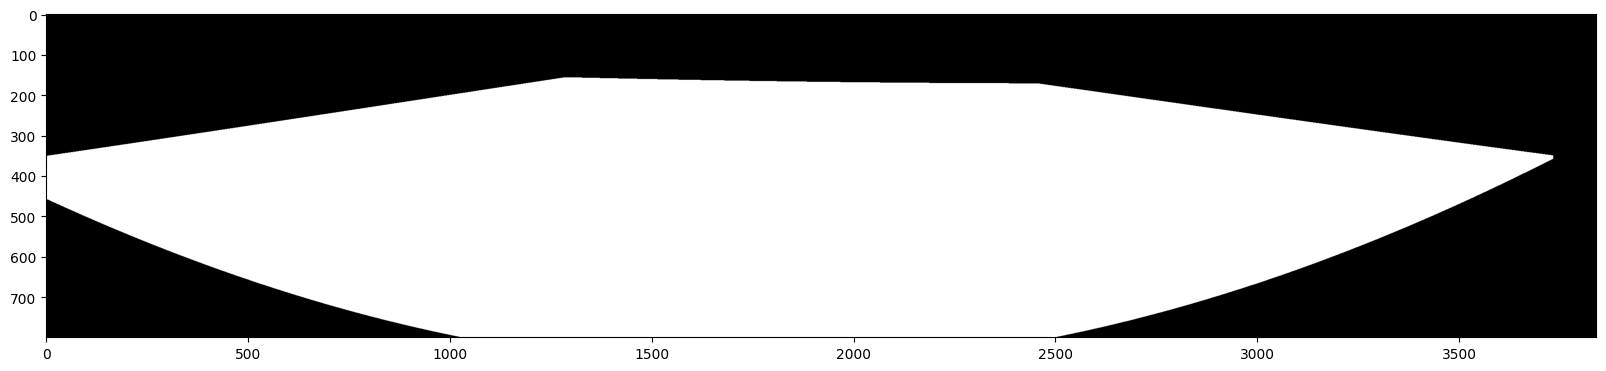

In [35]:
plt.figure(figsize=(20,10))
plt.imshow(court_mask)

In [36]:
video = VideoIterator(video_path)
video_basename = Path(video_path).stem
video_writer = None

In [37]:
model = YOLO(model_path)

In [ ]:
# Detect objects from classes 0 and 32 only
# classes = [0, 32]
# model.overrides["classes"] = classes

In [38]:
if sahi_inference:
    logger.info(f"Sahi based inferencing is enabled")
    model = AutoDetectionModel.from_pretrained(
        model_type=model_type,
        model=model,
        confidence_threshold=config.sahi.confidence_threshold,
        device="cuda:0" if torch.cuda.is_available() else "cpu",
    )

In [ ]:
# Output setup
# save_dir = increment_path(Path(v).parent / "results_sahi" / "exp", True)
# save_dir

In [ ]:
# save_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# image_files = list(Path(image_source).rglob("*.[jp][pn]g"))

# if not image_files:
#     raise FileNotFoundError(f"No image files found in: {image_source}")

In [ ]:
player_detections = {}
ball_detections = {}

In [ ]:
img_path = image_files[0]
img_path

In [ ]:
results = get_sliced_prediction(
    str(img_path),
    detection_model,
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)

In [ ]:
results.export_visuals(export_dir="sahi_sample/",
                    text_size=5,
                    rect_th=None,
                    hide_labels=True,
                    hide_conf=True,
                    file_name="custom_yolov8_prediction_visual",)
# Image("sahi_sample/prediction_visual.png")

In [ ]:
visual = cv2.imread("sahi_sample/custom_yolov8_prediction_visual.png")
visual = cv2.cvtColor(visual, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(visual)

In [ ]:
frame_number = img_path.stem
frame_number

In [ ]:
# !pip install -U imantics

In [ ]:
player_frame_detections = {}
ball_frame_detections = {}

for bboxid, detection in enumerate(results.object_prediction_list):
    if detection.category.name == 'player':
        player_frame_detections[bboxid] = {
                                            'bbox': [int(v) for v in detection.bbox.to_xyxy()],
                                            'score': round(detection.score.value, 5)
                                          }
    else:
        ball_frame_detections[bboxid] = {
                                            'bbox': [int(v) for v in detection.bbox.to_xyxy()],
                                            'score': round(detection.score.value, 5)
                                        }

In [ ]:
player_detections[frame_number] = player_frame_detections
ball_detections[frame_number] = ball_frame_detections

In [ ]:
debug = True

In [ ]:
frame_path

In [ ]:
output_dict = {
    "players": {},
    "ball": {},
    "debug": {
        "fps": fps,
        "image_h": height,
        "image_w": width,
        "model_name": args.model
    }
}


# Test function

In [3]:
import os
os.getcwd()

'/mnt/ai-storage/personal/pradip/st-ultralytics'

In [4]:
from scripts.inference_sahi import detect_bboxes_from_video

In [5]:
model_path = 'scripts/models/20231231_yolov8x-albumentations.pt'

In [6]:
video_path = '/mnt/ai-storage/jira/imtec356/ma25fad386_5100_5160/pano.mp4'

In [7]:
court_mask_path = '/mnt/ai-storage/jira/imtec356/ma25fad386_5100_5160/pano_mask.png'

In [8]:
detect_bboxes_from_video(video_path = video_path,
                         model_path = model_path,
                         model_type = "yolov8",
                         start_time = 0,
                         end_time = 100,
                         court_mask_path = court_mask_path,
                         confidence_threshold= 0.3,
                         verbosity = 1,
                         debug=True)

2024-03-13 10:31:25.287 | INFO     | scripts.inference_sahi:detect_bboxes_from_video:148 - out_dir is: /mnt/ai-storage/jira/imtec356/ma25fad386_5100_5160/sahi_detection_results
2024-03-13 10:31:25.288 | INFO     | scripts.inference_sahi:detect_bboxes_from_video:154 - out_path is: /mnt/ai-storage/jira/imtec356/ma25fad386_5100_5160/sahi_detection_results/pano.bbox
2024-03-13 10:31:25.290 | INFO     | scripts.inference_sahi:detect_bboxes_from_video:160 - Use court mask: /mnt/ai-storage/jira/imtec356/ma25fad386_5100_5160/pano_mask.png
Player Detection for pano - 0  to 100: 0it [00:00, ?it/s]

Performing prediction on 20 number of slices.


/mnt/ai-storage/pradip/miniconda3/envs/yolov5/lib/python3.8/site-packages/st_commons/data/data_loader.py:35: UserWarning: Use image_width instead, image_w deprecated since v 0.0.5
  warnings.warn("Use image_width instead, image_w deprecated since v 0.0.5")
/mnt/ai-storage/pradip/miniconda3/envs/yolov5/lib/python3.8/site-packages/st_commons/data/data_loader.py:40: UserWarning: Use image_height instead, image_h deprecated since v 0.0.5
  warnings.warn("Use image_height instead, image_h deprecated since v 0.0.5")
Player Detection for pano - 0  to 100: 1it [00:07,  7.15s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 2it [00:12,  6.09s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 3it [00:17,  5.70s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 4it [00:23,  5.54s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 5it [00:28,  5.44s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 6it [00:33,  5.38s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 7it [00:38,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 8it [00:44,  5.34s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 9it [00:49,  5.33s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 10it [00:54,  5.32s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 11it [01:00,  5.31s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 12it [01:05,  5.31s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 13it [01:10,  5.30s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 14it [01:15,  5.30s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 15it [01:21,  5.30s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 16it [01:26,  5.30s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 17it [01:31,  5.31s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 18it [01:37,  5.54s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 19it [01:45,  6.24s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 20it [01:53,  6.58s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 21it [01:59,  6.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.
Dumping final image to disk


Player Detection for pano - 0  to 100: 22it [02:04,  6.16s/it]

Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 23it [02:10,  5.93s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 24it [02:15,  5.77s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 25it [02:20,  5.66s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 26it [02:26,  5.59s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 27it [02:31,  5.54s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 28it [02:37,  5.52s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 29it [02:42,  5.49s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 30it [02:48,  5.47s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 31it [02:53,  5.45s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 32it [02:58,  5.44s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 33it [03:04,  5.43s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 34it [03:09,  5.42s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 35it [03:15,  5.42s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 36it [03:20,  5.42s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 37it [03:26,  5.42s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 38it [03:31,  5.42s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 39it [03:36,  5.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 40it [03:42,  5.42s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 41it [03:47,  5.42s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 42it [03:53,  5.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 43it [03:58,  5.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 44it [04:03,  5.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 45it [04:09,  5.42s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 46it [04:14,  5.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 47it [04:20,  5.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 48it [04:25,  5.40s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 49it [04:30,  5.40s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 50it [04:36,  5.40s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 51it [04:41,  5.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 52it [04:47,  5.40s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 53it [04:52,  5.40s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 54it [04:57,  5.40s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 55it [05:03,  5.40s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 56it [05:08,  5.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 57it [05:14,  5.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 58it [05:19,  5.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 59it [05:24,  5.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 60it [05:30,  5.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 61it [05:35,  5.40s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 62it [05:41,  5.41s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 63it [05:46,  5.40s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 64it [05:52,  5.42s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 65it [05:57,  5.39s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 66it [06:02,  5.37s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 67it [06:08,  5.36s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 68it [06:13,  5.36s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 69it [06:18,  5.36s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 70it [06:24,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 71it [06:29,  5.36s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 72it [06:34,  5.36s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 73it [06:40,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 74it [06:45,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 75it [06:50,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 76it [06:56,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 77it [07:01,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 78it [07:06,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 79it [07:12,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 80it [07:17,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 81it [07:22,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 82it [07:28,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 83it [07:33,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 84it [07:39,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 85it [07:44,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 86it [07:49,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 87it [07:55,  5.36s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 88it [08:00,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 89it [08:05,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 90it [08:11,  5.35s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 91it [08:16,  5.34s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 92it [08:21,  5.34s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 93it [08:27,  5.36s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 94it [08:32,  5.30s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 95it [08:37,  5.24s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 96it [08:42,  5.21s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 97it [08:47,  5.18s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 98it [08:52,  5.16s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 99it [08:57,  5.15s/it]

Dumping final image to disk
Performing prediction on 20 number of slices.


Player Detection for pano - 0  to 100: 100it [09:03,  5.43s/it]
2024-03-13 10:40:28.763 | SUCCESS  | scripts.inference_sahi:detect_bboxes_from_video:241 - Saved bbox detections to /mnt/ai-storage/jira/imtec356/ma25fad386_5100_5160/sahi_detection_results/pano.bbox
2024-03-13 10:40:28.771 | SUCCESS  | scripts.inference_sahi:detect_bboxes_from_video:244 - Saved bbox video to /mnt/ai-storage/jira/imtec356/ma25fad386_5100_5160/sahi_detection_results/pano.bbox.mp4


Dumping final image to disk
Inference with SAHI is done.


In [ ]:
out_path